In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import pearsonr, spearmanr


# Apple 기본 폰트인 'AppleGothic' 사용
mpl.rcParams['font.family'] = 'AppleGothic'

# 음수 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

In [2]:
df = (
    pd.read_csv("1st-dataset.csv", parse_dates=["game_date"])  # 날짜 파싱
)

df = df[df['sports_type'] == "농구"]

df.info()
#df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 563 entries, 2451 to 3013
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   game_id         563 non-null    int64         
 1   stadium_code    563 non-null    object        
 2   sports_type     563 non-null    object        
 3   game_date       563 non-null    datetime64[ns]
 4   day_of_week     563 non-null    object        
 5   is_holiday      563 non-null    int64         
 6   start_time      563 non-null    object        
 7   home_team_win   563 non-null    int64         
 8   match_type      563 non-null    object        
 9   audience        563 non-null    int64         
 10  region          563 non-null    object        
 11  accident_count  563 non-null    float64       
 12  injury_count    563 non-null    float64       
 13  death_count     563 non-null    float64       
 14  temperature     563 non-null    float64       
 15  precipi

In [4]:
df.match_type.unique()
# 기본 치환: '페넌트레이스'·'순위결정전'(오탈자 '순위결정정' 포함)·'0' --> '정규시즌'
df["match_type"] = (
    df["match_type"]
        .replace({"페넌트레이스": "정규시즌",
                  "순위결정전": "정규시즌",
                  "순위결정정": "정규시즌",   # 오타까지 함께 처리
                  '조별리그' : "정규시즌",
                  "0": "정규시즌"})
        # ➋ 라운드 표기(1R ~ 33R 등) → 정규시즌
        .str.replace(r"^\d+R$", "정규시즌", regex=True)
)

df["match_type"] = (
    df["match_type"]
        .replace({'와일드카드':"포스트시즌",
                '준플레이오프':"포스트시즌", 
                '플레이오프':"포스트시즌", 
                '한국시리즈':"포스트시즌",
                '파이널 라운드A':"포스트시즌",
                '파이널 라운드B':"포스트시즌",
                '챔피언결정전':"포스트시즌", 
                '준결승':"포스트시즌", 
                '결승':"포스트시즌"})
)
# 결과 확인
print(df["match_type"].unique())

['정규시즌' '올스타전' '포스트시즌']


In [5]:
# 문자열을 timedelta64로 변환
df['start_time'] = pd.to_timedelta(df['start_time'])

# 시작시각 → 시간 숫자(0~23) 추출
df["start_hour"] = df['start_time'].dt.components['hours']

# 요일 숫자 & 카테고리 정렬
weekday_map = ["월","화","수","목","금","토","일"]
df["day_of_week_cat"] = pd.Categorical(df["day_of_week"],
                                       categories=weekday_map, ordered=True)

# 수치/범주 변수 분리
num_cols  = ["injury_count","death_count",
             "temperature","precipitation","snow_depth","start_hour"]
cat_cols  = ["region","sports_type","match_type",
             "home_team_win","is_holiday","day_of_week_cat"]


/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL})

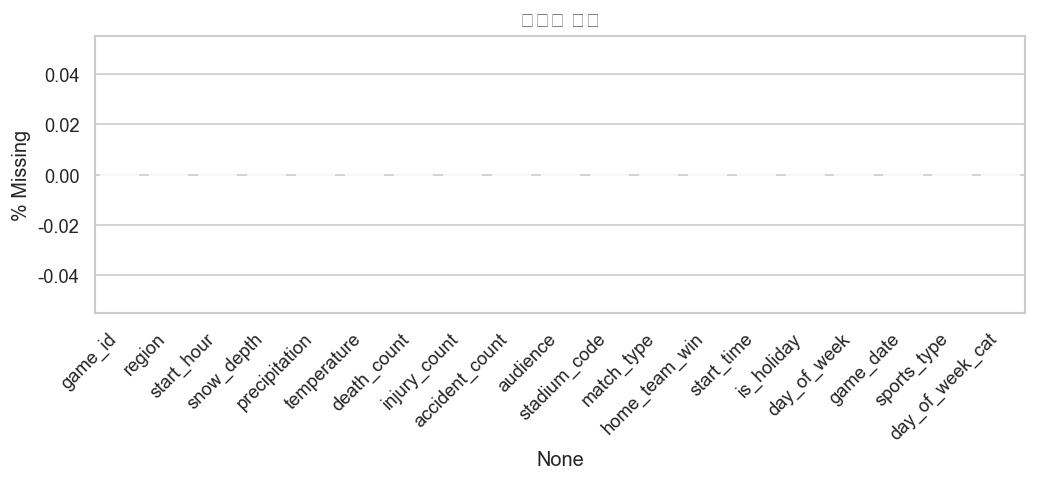

In [6]:
# -------------------- 3-1. 품질·결측치 시각화 ---------------
na_pct = df.isna().mean().mul(100).sort_values(ascending=False)
plt.figure(figsize=(10,3))
sns.barplot(x=na_pct.index, y=na_pct.values)
plt.xticks(rotation=45, ha="right"); plt.ylabel("% Missing")
plt.title("결측치 비율"); plt.show()

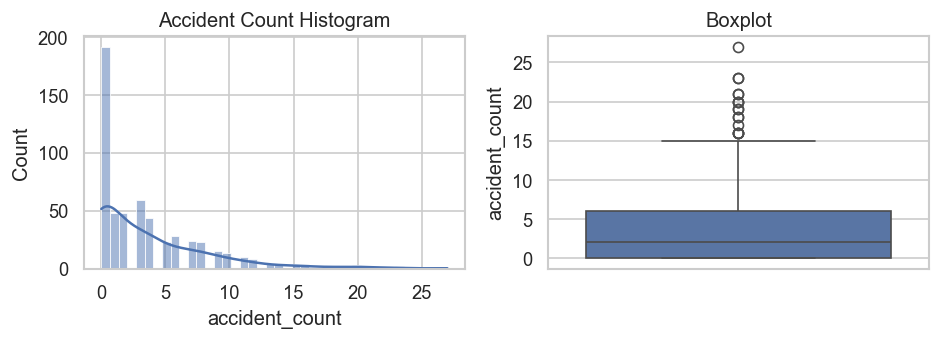

In [7]:
# -------------------- 3-2. 사고건수 기본 분포 ----------------
fig, ax = plt.subplots(1,2,figsize=(8,3))
sns.histplot(df["accident_count"], bins=40, kde=True, ax=ax[0])
ax[0].set_title("Accident Count Histogram")
sns.boxplot(y=df["accident_count"], ax=ax[1])
ax[1].set_title("Boxplot")
plt.tight_layout(); plt.show()

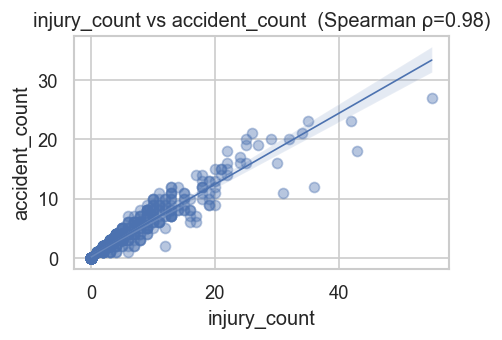

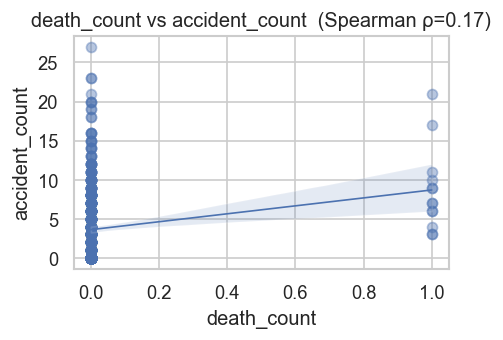

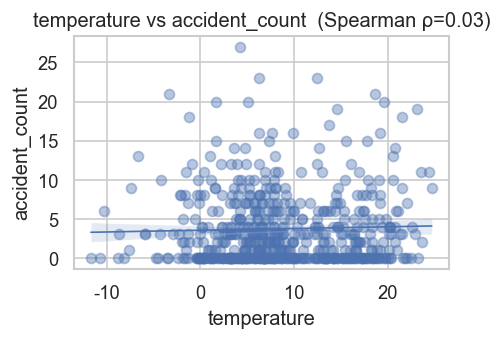

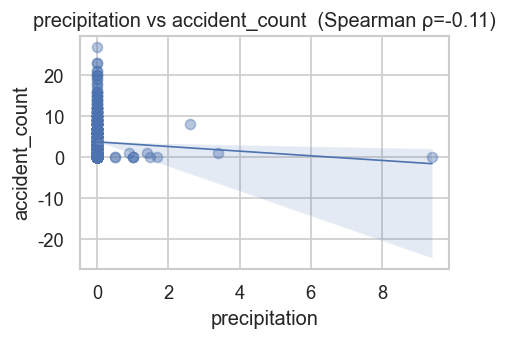

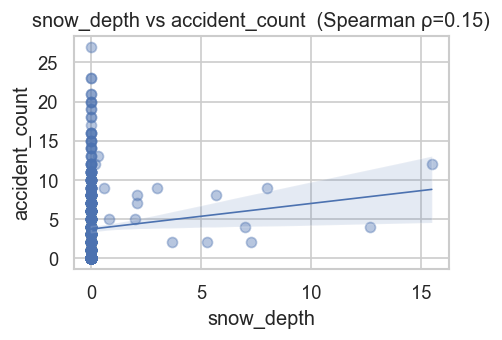

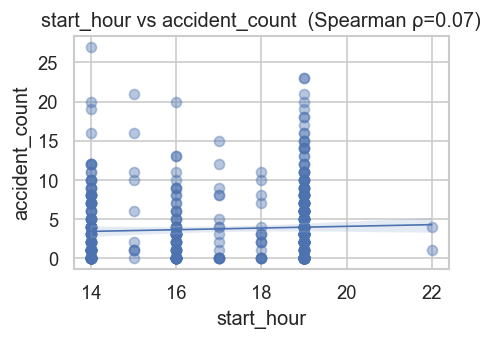

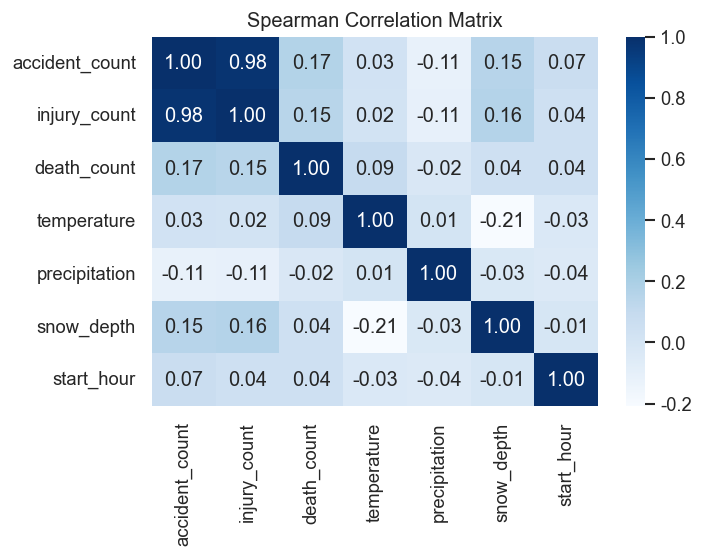

In [8]:
# -------------------- 3-3. 수치형 ↔ 사고건수 관계 ------------
# (a) 산점도 + 선형회귀선
for col in num_cols:
    plt.figure(figsize=(4,3))
    sns.regplot(x=col, y="accident_count", data=df,
                scatter_kws={'alpha':0.4}, line_kws={'lw':1})
    r, p = spearmanr(df[col], df["accident_count"], nan_policy='omit')
    plt.title(f"{col} vs accident_count  (Spearman ρ={r:.2f})")
    plt.tight_layout(); plt.show()

# (b) 상관계수 히트맵
corr = df[["accident_count"] + num_cols].corr(method="spearman")
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues")
plt.title("Spearman Correlation Matrix"); plt.show()

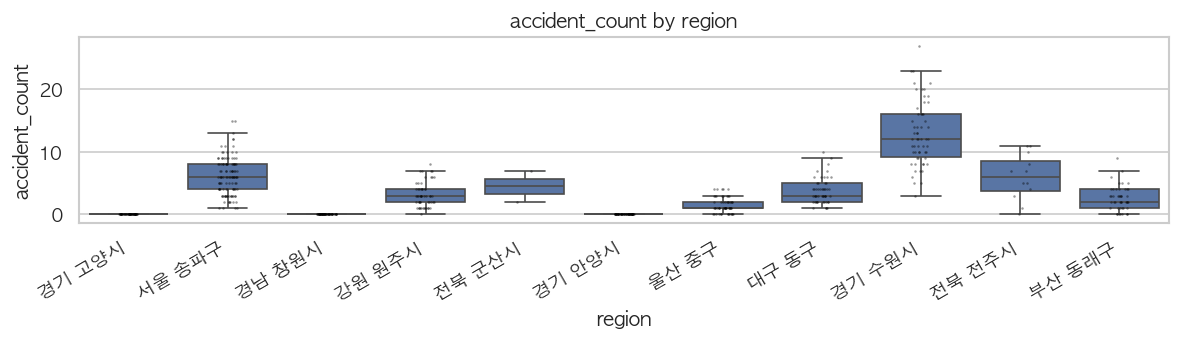

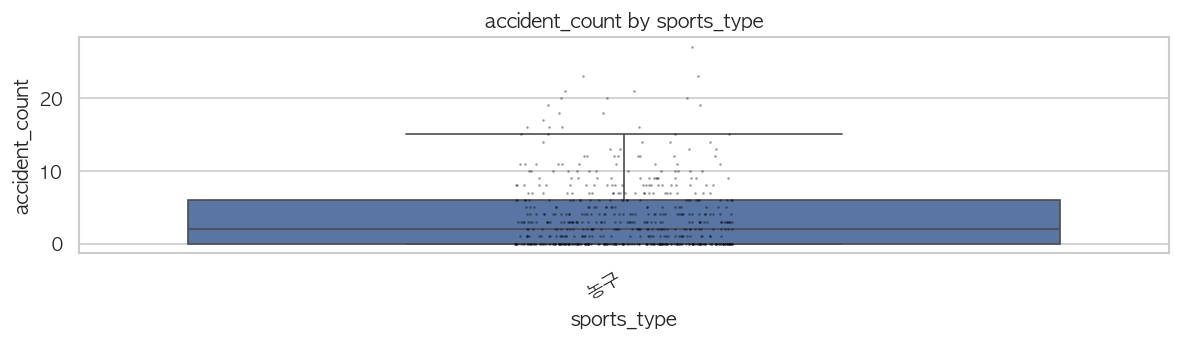

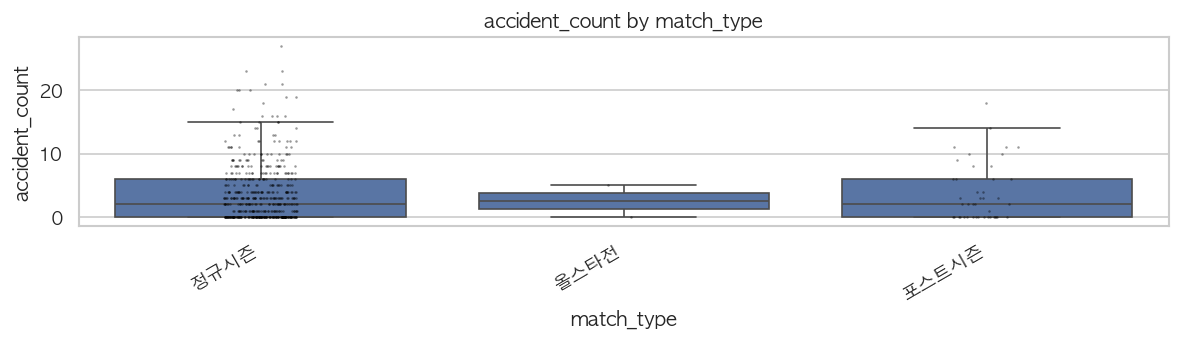

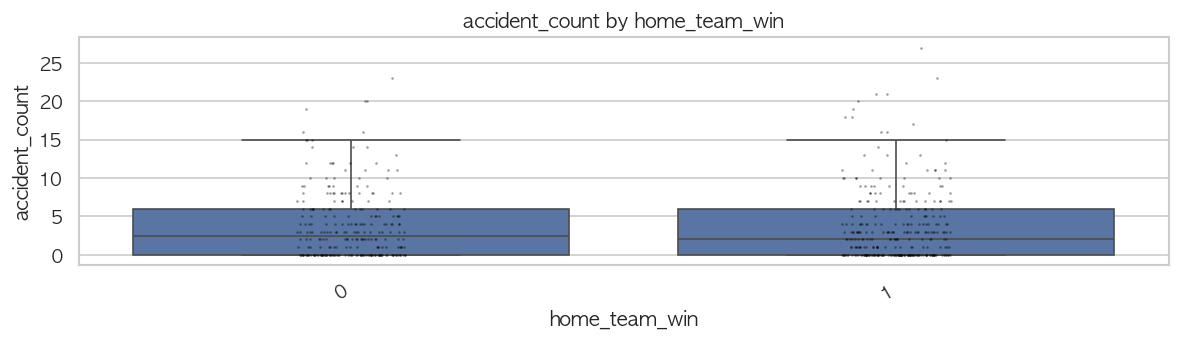

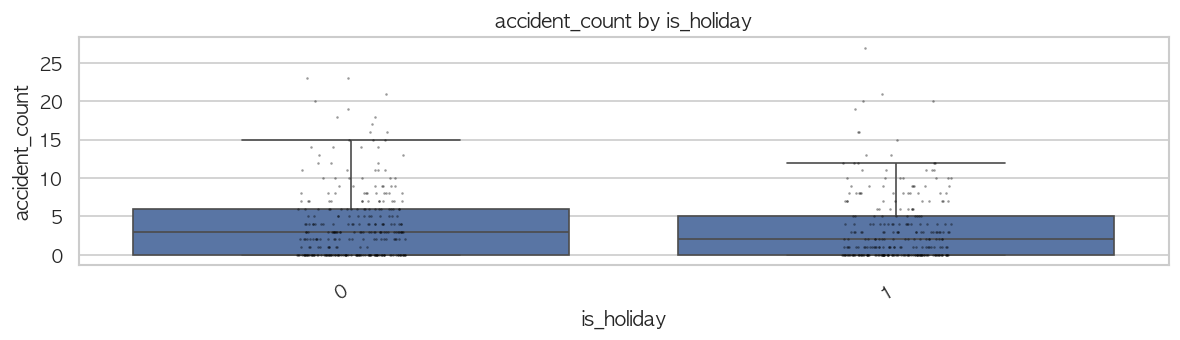

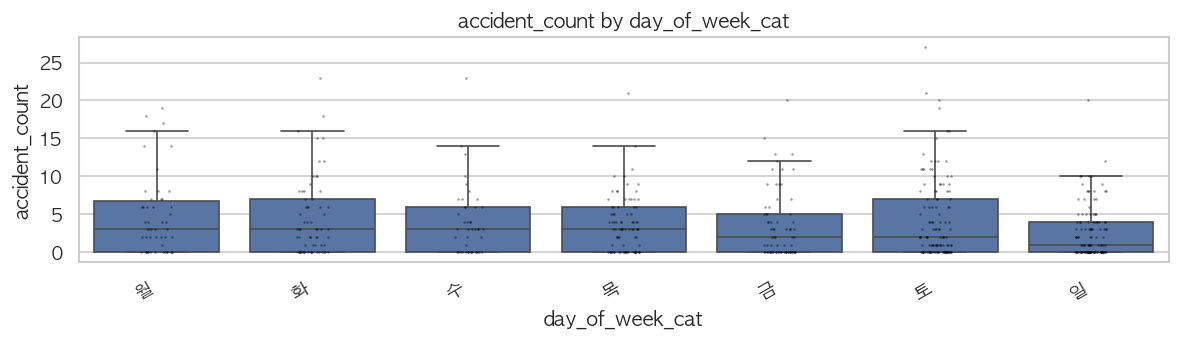

In [9]:
# -------------------- 3-4. 범주형 ↔ 사고건수 -----------------
# Apple 기본 폰트인 'AppleGothic' 사용
mpl.rcParams['font.family'] = 'AppleGothic'

# 음수 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

for col in cat_cols:
    plt.figure(figsize=(10,3))
    sns.boxplot(x=col, y="accident_count", data=df,
                showfliers=False)
    sns.stripplot(x=col, y="accident_count", data=df,
                  color='black', size=1.5, alpha=0.4)
    plt.title(f"accident_count by {col}")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout(); plt.show()

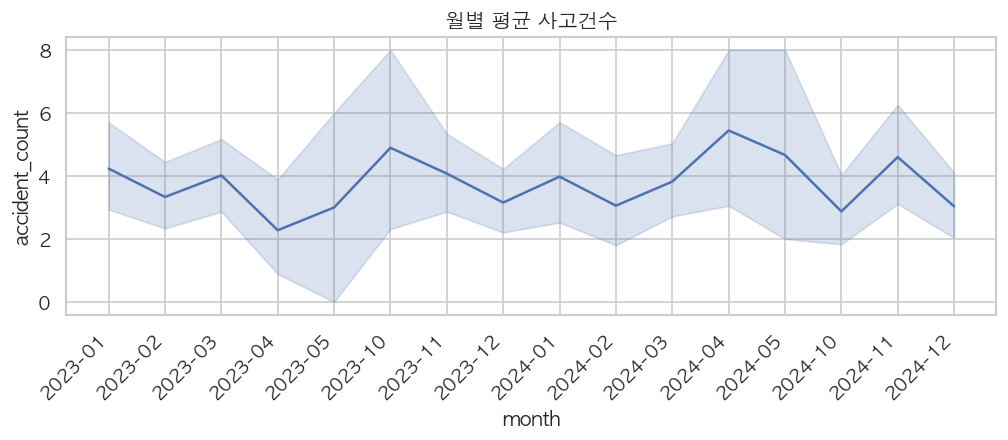

/var/folders/5k/zrsrnd7s18b7z_zm0b5yktj40000gn/T/ipykernel_74958/533077419.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="start_hour", y="accident_count", data=df,


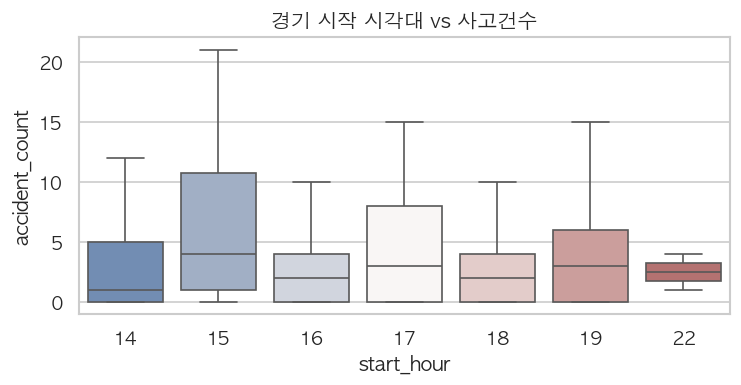

In [10]:
# -------------------- 3-5. 시계열 & 시간대 ------------------
# (a) 월별 평균
df["month"] = df["game_date"].dt.to_period("M")
plt.figure(figsize=(10,3))
sns.lineplot(x=df["month"].astype(str), y="accident_count",
             estimator="mean", errorbar="ci", data=df)
plt.xticks(rotation=45, ha="right"); plt.title("월별 평균 사고건수"); plt.show()

# (b) 시작 시간대별 분포
plt.figure(figsize=(7,3))
sns.boxplot(x="start_hour", y="accident_count", data=df,
            palette="vlag", showfliers=False)
plt.title("경기 시작 시각대 vs 사고건수"); plt.show()

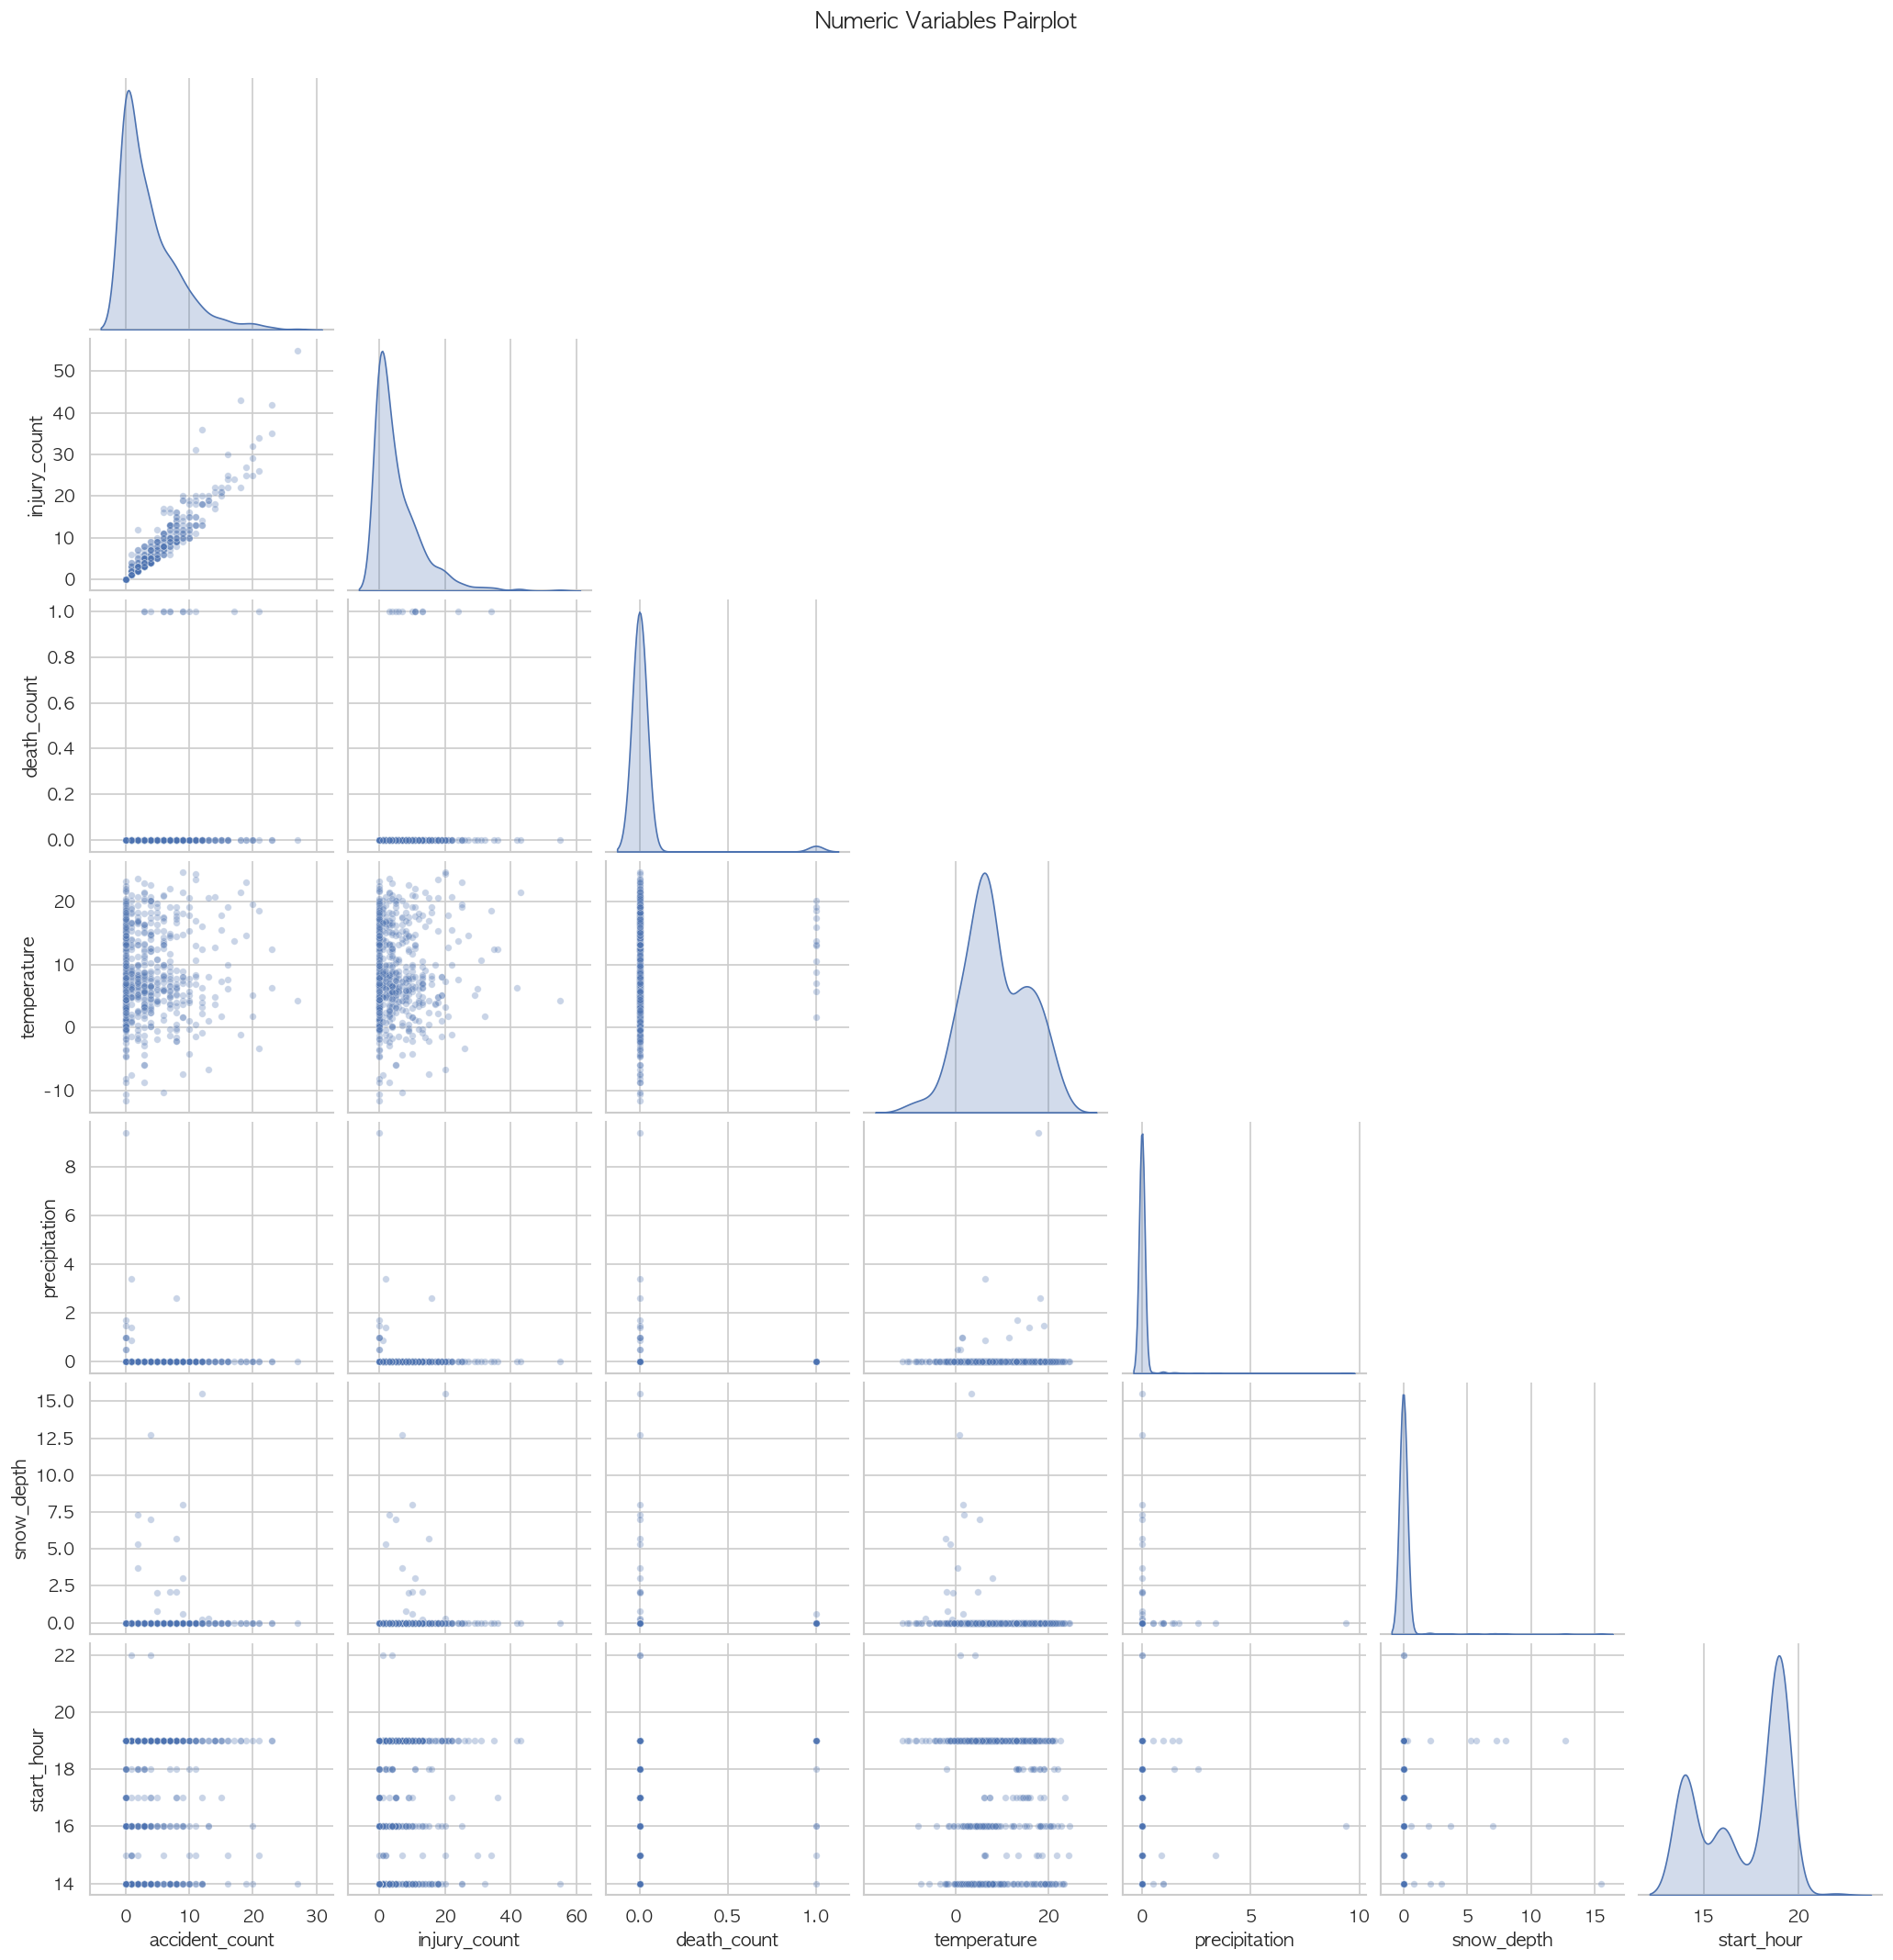

In [11]:
# -------------------- 3-6. 다중 상관 Pairplot ----------------
sns.pairplot(df[["accident_count"] + num_cols], diag_kind="kde",
             corner=True, plot_kws={'alpha':0.3, 's':20})
plt.suptitle("Numeric Variables Pairplot", y=1.02); plt.show()

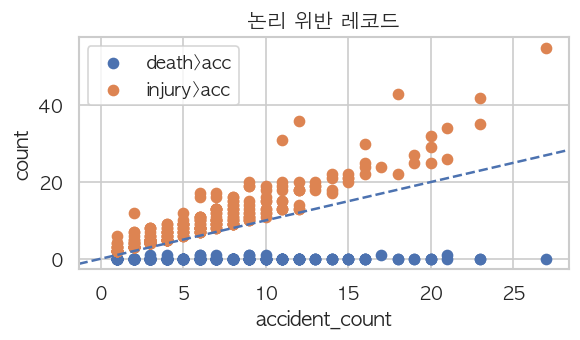

In [12]:
# -------------------- 3-7. 이상치·논리제약 -------------------
# 사망·부상 > 사고건수 레코드 표시
viol = df[(df["death_count"] > df["accident_count"])
          | (df["injury_count"] > df["accident_count"])]
if not viol.empty:
    plt.figure(figsize=(5,3))
    plt.scatter(viol["accident_count"], viol["death_count"], label="death>acc")
    plt.scatter(viol["accident_count"], viol["injury_count"], label="injury>acc")
    plt.axline((0,0),(1,1), linestyle="--"); plt.legend()
    plt.xlabel("accident_count"); plt.ylabel("count")
    plt.title("논리 위반 레코드"); plt.tight_layout(); plt.show()

In [13]:
# 포아송 분포를 이용한 

from scipy.stats import mannwhitneyu
import statsmodels.api as sm
import statsmodels.formula.api as smf

rs = df.query("match_type == '정규시즌'")
ps = df.query("match_type == '포스트시즌'")

# 경기당 평균·신뢰구간(부트스트랩) ───────────────
def bootstrap_mean(series, n_boot=5000):
    boot = np.random.choice(series, (n_boot, len(series)), replace=True).mean(axis=1)
    return boot.mean(), np.percentile(boot, [2.5, 97.5])

rs_mu, rs_ci = bootstrap_mean(rs["accident_count"])
ps_mu, ps_ci = bootstrap_mean(ps["accident_count"])
print(f"RS μ={rs_mu:.2f} ({rs_ci[0]:.2f}–{rs_ci[1]:.2f})")
print(f"PS μ={ps_mu:.2f} ({ps_ci[0]:.2f}–{ps_ci[1]:.2f})")

# 비모수 검정 ──────────────────────────────────
u, p = mannwhitneyu(ps["accident_count"], rs["accident_count"], alternative='two-sided')
print(f"Mann-Whitney U p-value = {p:.4f}")

# Poisson 회귀(경기수 차 고려) ────────────────
# 사고 건수를 종속변수, match_type(PS vs RS) 더미만 고려한 단순 모델
df["is_PS"] = (df["match_type"] == "포스트시즌").astype(int)
model = smf.glm("accident_count ~ is_PS", data=df,
                family=sm.families.Poisson()).fit()
print(model.summary())
rr = np.exp(model.params["is_PS"])
ci_low, ci_high = np.exp(model.conf_int().loc["is_PS"])
print(f"Incidence-Rate-Ratio (IRR) = {rr:.2f} ({ci_low:.2f}–{ci_high:.2f})")

RS μ=3.73 (3.34–4.14)
PS μ=3.82 (2.53–5.23)
Mann-Whitney U p-value = 0.9017
                 Generalized Linear Model Regression Results                  
Dep. Variable:         accident_count   No. Observations:                  563
Model:                            GLM   Df Residuals:                      561
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2074.9
Date:                Mon, 02 Jun 2025   Deviance:                       2916.2
Time:                        11:21:24   Pearson chi2:                 3.12e+03
No. Iterations:                     5   Pseudo R-squ. (CS):          0.0002441
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------